# Part 2: Story-to-Storyboard Generation with Hugging Face Stable Diffusion

**Objective:** This notebook demonstrates how to use the Hugging Face `diffusers` library, specifically the Stable Diffusion pipeline, to generate a sequence of images (a storyboard) from a given textual story. The process involves segmenting the story, creating visual prompts from these segments, and then generating an image for each prompt.

---

## 1. Setup and Prerequisites

This section covers the initial setup, including installing necessary libraries, importing modules, and configuring the environment.

### 1.1. Install Libraries

Ensure all required libraries are installed. If running in a new environment, you might need to uncomment and run the installation commands.

In [1]:
pip install diffusers

### 1.2. Import Libraries

In [2]:
from transformers import pipeline
from diffusers import StableDiffusionPipeline
from PIL import Image
import matplotlib.pyplot as plt
import torch
import nltk
import os

In [3]:
nltk.download('punkt_tab')
nltk.download('punkt')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### 1.3. Configure Environment and Device

In [4]:
summarizer = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6")
sd_pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
sd_pipe.to("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

Device set to use cuda:0


model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.33.1",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

### 3.2.1. Advanced Segmentation with `segment_story` (Optional)

For more controlled segmentation, especially to ensure prompts for the image generation model do not exceed a certain token limit (approximated by word count here), we can define a function that first tokenizes the story into sentences and then groups these sentences into chunks.

**Function: `segment_story(story, max_tokens=30)`**

**Purpose:**
This function takes a longer story string and divides it into smaller text segments or "chunks." Each chunk is formed by concatenating sentences until the total number of words in the chunk is close to, but does not exceed, `max_tokens`. This is useful for creating manageable pieces of text that can be effectively converted into prompts for image generation, preventing prompts from becoming too long or losing focus.

**Dependencies:**
* `nltk` (Natural Language Toolkit): Specifically, `nltk.sent_tokenize` is used for sentence tokenization. You'll need to ensure NLTK is installed (`pip install nltk`) and the `punkt` tokenizer models are downloaded (`nltk.download('punkt')` in Python).

**Parameters:**
* `story` (str): The full text of the story to be segmented.
* `max_tokens` (int, optional): The approximate maximum number of words desired per chunk. Defaults to `30`. Note that this is based on space-separated words and serves as a proxy for actual model tokens.

**Process:**
1.  **Sentence Tokenization**: The input `story` is first split into individual sentences using `nltk.sent_tokenize()`.
2.  **Chunk Creation**:
    * It iterates through the tokenized sentences.
    * It attempts to add the current sentence to the `current_chunk`.
    * If adding the sentence (plus a space) keeps the word count of `current_chunk` below `max_tokens`, the sentence is appended.
    * If adding the sentence would exceed `max_tokens`, the `current_chunk` (as it is) is added to the list of `chunks`, and the `current_chunk` is reset to start with the current sentence.
3.  **Final Chunk**: After iterating through all sentences, any remaining content in `current_chunk` is added as the last chunk to the `chunks` list.
4.  **Cleaning**: Each chunk has leading/trailing whitespace removed using `.strip()`.

In [5]:
def segment_story(story, max_tokens=30):
    raw_scenes = nltk.sent_tokenize(story)
    chunks = []
    chunk = ""
    for sent in raw_scenes:
        if len(chunk.split()) + len(sent.split()) < max_tokens:
            chunk += " " + sent
        else:
            chunks.append(chunk.strip())
            chunk = sent
    if chunk:
        chunks.append(chunk.strip())
    return chunks

### Story Helper Functions (Concise Overview)

* **`generate_visual_prompts(scenes)`**:
    * Takes story segments, summarizes each, and adds style keywords to create visual prompts for image generation.

* **`generate_image(prompt, index)`**:
    * Generates an image from a given prompt using the Stable Diffusion pipeline.
    * Saves the image with a unique filename based on the provided index and returns the filename.

* **`display_storyboard(images_and_prompts)`**:
    * Takes a list of prompts and their corresponding image filepaths.
    * Displays these images and prompts together in a storyboard layout using `matplotlib`.

In [6]:
def generate_visual_prompts(scenes):
    prompts = []
    for scene in scenes:
        summary = summarizer(scene, max_length=30, min_length=10, do_sample=False)[0]['summary_text']
        visual_prompt = f"{summary}, highly detailed, cinematic, fantasy art"
        prompts.append(visual_prompt)
    return prompts

In [7]:
def generate_image(prompt, index):
    image = sd_pipe(prompt).images[0]
    filename = f"scene_{index}.png"
    image.save(filename)
    return filename

In [8]:
def display_storyboard(images_and_prompts):
    cols = min(4, len(images_and_prompts))
    plt.figure(figsize=(4 * cols, 5))
    for i, (prompt, file) in enumerate(images_and_prompts):
        img = Image.open(file)
        plt.subplot(1, len(images_and_prompts), i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Scene {i+1}", fontsize=8)
        plt.xlabel(prompt[:60] + "...")
    plt.tight_layout()
    plt.show()

## 5. Generating and Displaying the Storyboard

This section brings together all the defined components: the story, segmentation, prompt generation, image generation, and storyboard display.

**Prerequisites:**
* The helper functions `segment_story`, `generate_visual_prompts`, `generate_image`, and `display_storyboard` must be defined.
* Necessary libraries and models must be initialized:
    * `nltk` for sentence tokenization (used by `segment_story`).
    * A `summarizer` pipeline (e.g., from Hugging Face Transformers, used by `generate_visual_prompts`).
    * An `sd_pipe` (e.g., a Hugging Face `StableDiffusionPipeline`, used by `generate_image`).
    * `matplotlib.pyplot` and `PIL.Image` for displaying images (used by `display_storyboard`).

**Workflow:**

1.  **Define the Story:**
    * A multi-line string variable `story` is defined, containing the narrative to be visualized.

2.  **Segment the Story:**
    * `scenes = segment_story(story)`: The `story` is passed to the `segment_story` function (which likely uses a `max_tokens` or `max_words` argument, assumed to be using its default here or set globally). This breaks the story into smaller, manageable text segments or scenes.

3.  **Generate Visual Prompts:**
    * `visual_prompts = generate_visual_prompts(scenes)`: The list of `scenes` is then processed by `generate_visual_prompts`. This function (likely using a summarizer and appending style keywords) converts each text segment into a more descriptive prompt suitable for image generation.
    * The generated `visual_prompts` are then printed to the console for review, allowing the user to see what prompts will be fed to the image generation model.

4.  **Generate Images for Each Prompt:**
    * `image_files = [(prompt, generate_image(prompt, i)) for i, prompt in enumerate(visual_prompts)]`: This line uses a list comprehension to iterate through each `prompt` in `visual_prompts`.
    * For each prompt, `generate_image(prompt, i)` is called. This function uses the Stable Diffusion pipeline (`sd_pipe`) to create an image, saves it to a file (e.g., `scene_0.png`, `scene_1.png`, etc., based on the index `i`), and returns the filename.
    * The result, `image_files`, is a list of tuples, where each tuple contains the original `prompt` and the `filename` of the generated image corresponding to that prompt.

5.  **Display the Storyboard:**
    * `display_storyboard(image_files)`: Finally, the `image_files` list (containing prompt-filename pairs) is passed to the `display_storyboard` function. This function loads each image from its file and displays them sequentially, typically in a grid format using `matplotlib`, creating the final visual storyboard. Each image might be accompanied by its scene number or a snippet of its prompt.

**Expected Output:**
* A printed list of the "Visual Prompts" that were generated from the story segments.
* A series of image files saved to disk (e.g., `scene_0.png`, `scene_1.png`, ...).
* A Matplotlib plot displaying these images in a storyboard format.

This code block represents the core execution logic of the story-to-storyboard generation process.

In [15]:
story = """
Leo, a brave young eagle, soared high above the misty mountains.
He heard a faint, sad cry echo from a deep, hidden valley below.
Curious, Leo glided down and found a small, fluffy wolf cub, lost and alone.
The cub whimpered, pointing a paw towards a distant, snow-capped peak.
Leo understood and gently nudged the cub, offering to guide it.
Together, the eagle flying above and the cub trotting below, they journeyed towards the peak to find the cub's family.
"""
scenes = segment_story(story)
visual_prompts = generate_visual_prompts(scenes)


Your max_length is set to 30, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 30, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


In [16]:
print("Visual Prompts:")
for i, prompt in enumerate(visual_prompts):
    print(f"{i+1}. {prompt}")

Visual Prompts:
1.  Leo, a brave young eagle, soared high above the misty mountains . He heard a faint, sad cry echo from a deep,, highly detailed, cinematic, fantasy art
2.  Leo glided down and found a small, fluffy wolf cub, lost and alone . The cub whimpered, pointing a paw towards a, highly detailed, cinematic, fantasy art
3.  Leo understood and gently nudged the cub, offering to guide it ., highly detailed, cinematic, fantasy art
4.  The eagle and cubs journeyed towards the peak to find the cub's family . Together, the eagle flying above and the cub tro, highly detailed, cinematic, fantasy art


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

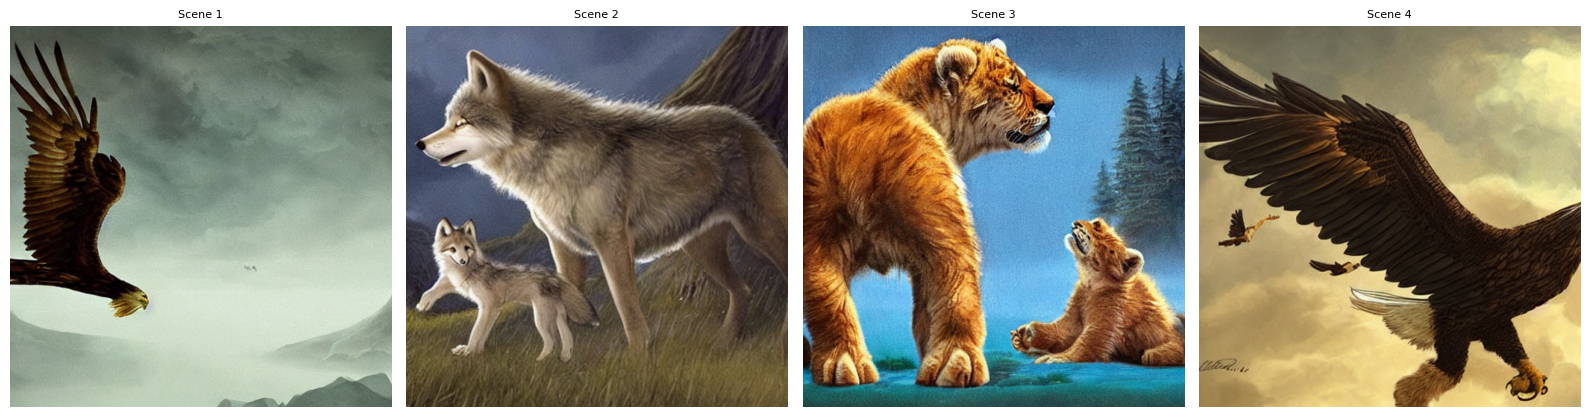

In [17]:
image_files = [(prompt, generate_image(prompt, i)) for i, prompt in enumerate(visual_prompts)]
display_storyboard(image_files)